In [1]:
import cv2
import os
import numpy as np
import random
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import loguniform
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
PATH = '/kaggle/input/facess/content/data'
WIDTH = 224
HEIGHT = 224

In [3]:
PATHH = '/kaggle/input/facess/content/data'

In [4]:
images = []
labels = []

In [5]:
for label in ['negative', 'positive', 'anchor']:
    folder = os.path.join(PATHH, label, 'face')
    count = 0
    for filename in os.listdir(folder):
      if (label in ['anchor', 'positive'] and count == 300) or (label == 'negative' and count == 600):
        break

      image_path = os.path.join(folder, filename)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (WIDTH, HEIGHT))
      images.append(image)

      if label == 'anchor':
        labels.append('positive')
        count += 1
        continue

      labels.append(label)
      count += 1

print(len(images))

1200


In [6]:
print(set(labels))

{'negative', 'positive'}


In [7]:
indexes = [random.randint(0, len(images) - 1) for _ in range(9)]
indexes

[566, 225, 1187, 1094, 484, 308, 1178, 1155, 434]

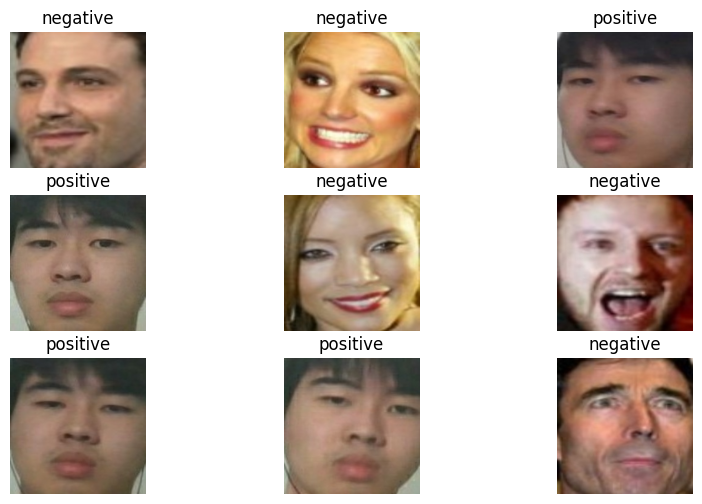

In [8]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]
    plt.subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

plt.show()

In [9]:
le = LabelEncoder()
Labels= le.fit_transform(labels)

In [10]:
images_gray = [cv2.cvtColor(images[i] , cv2.COLOR_BGR2GRAY) for i in range(len(images))]

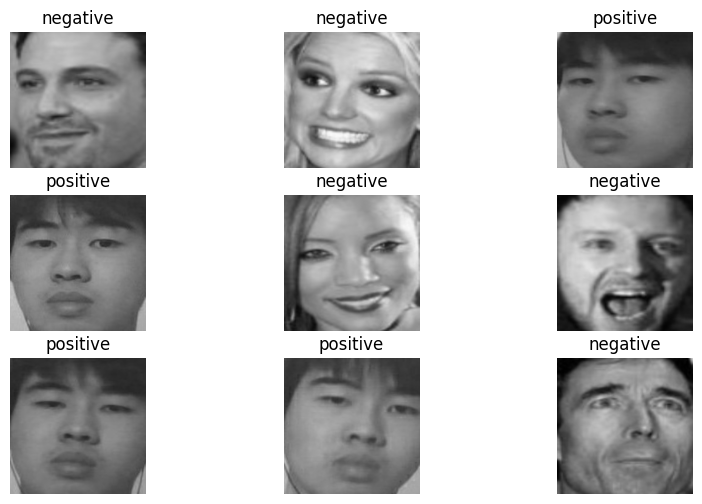

In [11]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]
    plt.subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(images_gray[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

plt.show()

In [12]:
Labels = np.array(Labels).reshape(len(Labels),1)

In [13]:
hog_features = []
hog_images = []
for image in tqdm(images_gray):
    fd , hogim = hog(image , orientations=9 , pixels_per_cell=(16, 16) , block_norm='L2' , cells_per_block=(4, 4) , visualize=True)
    hog_images.append(hogim)
    hog_features.append(fd)

100%|██████████| 1200/1200 [01:09<00:00, 17.24it/s]


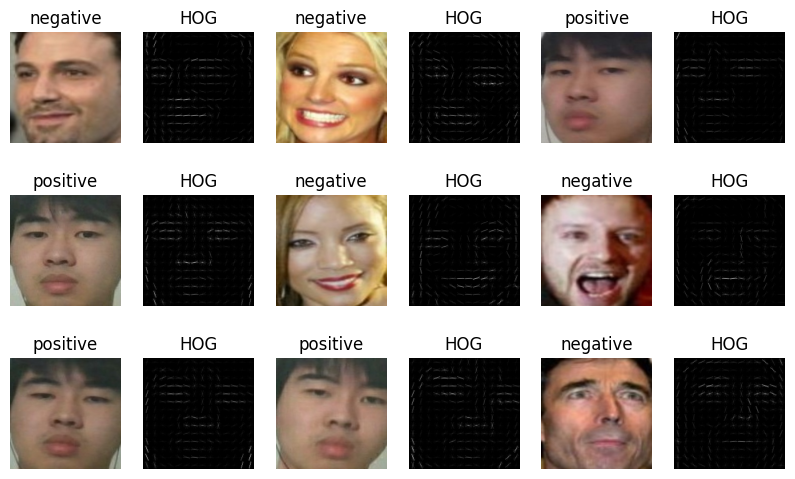

In [14]:
fig = plt.figure(figsize=(10, 6))
for i in range(1, 10):
    index = indexes[i-1]

    # Original image
    plt.subplot(3, 6, 2 * i - 1)
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
    plt.title(labels[index])
    plt.axis('off')

    # HOG
    hog_im_normalized = cv2.normalize(hog_images[index], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    plt.subplot(3, 6, 2 * i)
    plt.imshow(hog_im_normalized, cmap="gray")
    plt.title("HOG")
    plt.axis('off')

plt.show()

In [15]:
hog_features = np.array(hog_features)
df = np.hstack((hog_features,Labels))

In [16]:
df = shuffle(df, random_state=42)

In [17]:
X = df[:,:-1]
Y = df[:,-1]

In [18]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size=0.3 ,random_state=42)

In [19]:
pca = PCA(n_components=2, svd_solver='randomized').fit(X_train)

In [20]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_train_pca, Y_train);

In [22]:
y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8972
Precision: 0.9682
Recall: 0.8261


In [23]:
joblib.dump(model, "svm.pkl")
joblib.dump(pca, "pca.pkl")

['pca.pkl']

In [28]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_pca, Y_train);

In [29]:
y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9028
Precision: 0.9515
Recall: 0.8533


In [30]:
joblib.dump(model, "knn.pkl")

['knn.pkl']